**<span style="font-size: 24px;">Import Packages</span>**

In [20]:
# packages used in this tutorial 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

import numpy as np
import tensorflow as tf
from tensorflow import keras
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import precision_score, recall_score, confusion_matrix, classification_report, accuracy_score, f1_score
import joblib

**<span style="font-size: 24px;">Load CSVs</span>**

In [21]:
# Load the CSV files into dataframes
dataframes = {}
keys = [str(i).zfill(2) for i in range(1, 13)] # strings '01' to '12'
for key in keys:
    df = pd.read_csv(f'CSVafterClean/{key}.csv')
    dataframes[key] = df


**<span style="font-size: 24px;">Data Exploration - Target Variable</span>**

In [22]:
# Create an empty list to store the concatenated data
concatenated_data = []
for i in dataframes:
    df = dataframes[i]
    # Add a 'Month' column to each dataframe
    snip = df.loc[:, df.columns.isin(['time', 'prcp_total'])]
    concatenated_data.append(snip)
    
# Concatenate dataframes vertically
combined_df = pd.concat(concatenated_data, ignore_index=True) #size is [101835 rows x 2 columns]

# Convert 'time' column to datetime
combined_df['time'] = pd.to_datetime(combined_df['time'])

# Group by date and calculate the average precipitation for each day
aggregated_df = combined_df.groupby(combined_df['time'].dt.date)['prcp_total'].mean().reset_index()

print(aggregated_df)

           time  prcp_total
0    2015-01-01    1.136654
1    2015-01-02    0.258093
2    2015-01-03    0.274102
3    2015-01-04    0.086851
4    2015-01-05    0.565326
..          ...         ...
360  2015-12-27    0.192383
361  2015-12-28    0.392772
362  2015-12-29    0.158494
363  2015-12-30    1.181893
364  2015-12-31    0.337404

[365 rows x 2 columns]


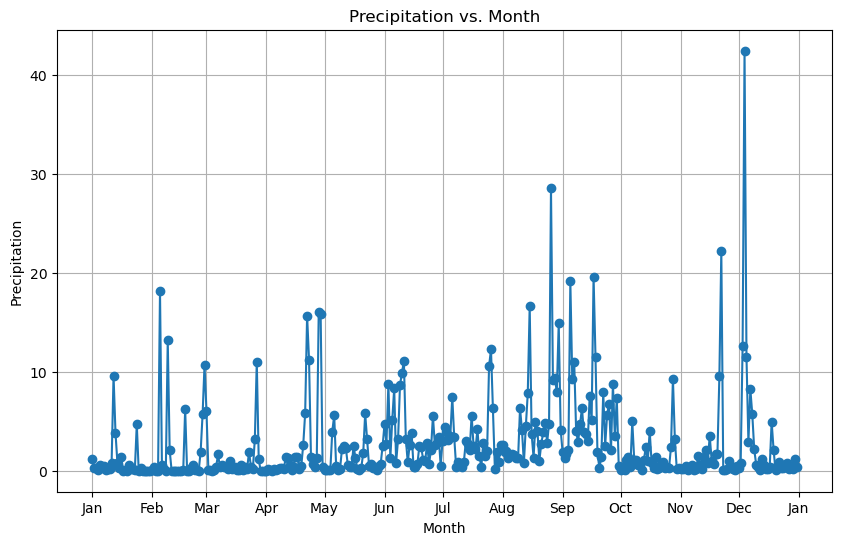

In [23]:
# Group by date and calculate the average precipitation for each day
aggregated_df = combined_df.groupby(combined_df['time'].dt.date)['prcp_total'].mean().reset_index()

# Create a line graph
plt.figure(figsize=(10, 6))
plt.plot(aggregated_df['time'], aggregated_df['prcp_total'], marker='o', linestyle='-')
plt.xlabel('Month')
plt.ylabel('Precipitation')
plt.title('Precipitation vs. Month')
plt.grid(True)

# Format the x-axis ticks to show one label per month
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))  # Set tick interval to 1 month

plt.show()

**<span style="font-size: 24px;">Data Preprocessing</span>**

In [24]:
# Assuming 'dataframes' is your dictionary of dataframes
# Extract the 'prcp_total' column from each dataframe
X = []  # Input features
y = []  # Target variable

# List of columns to exclude
target = 'next_day_prcp_total'
exclude_columns = ['time','lat','lon', target]

for key, df in dataframes.items():
     # Select all columns except 'time', and 'prcp_total' temporal aspects
    features = df.loc[:, ~df.columns.isin(exclude_columns)].values
    X.append(features) #a list of arrays, where each array represents the features for one dataframe. These arrays have the same number of columns (features).
    y.append(df[target].values) #a list of 1D NumPy arrays, where each array represents the 'prcp_total' values (target variable) for one dataframe

# Combine data from all dataframes
X = np.vstack(X) #vertically stacks (concatenates) these arrays on top of each other, effectively combining into a single 2D NumPy array of input features.
#where each row represents a data point (sample), and each column represents a feature.
y = np.concatenate(y) # y becomes a 1D array of target data point values of the one target variable


**<span style="font-size: 24px;">Data Visualization - Feature Importance</span>**

<AxesSubplot:>

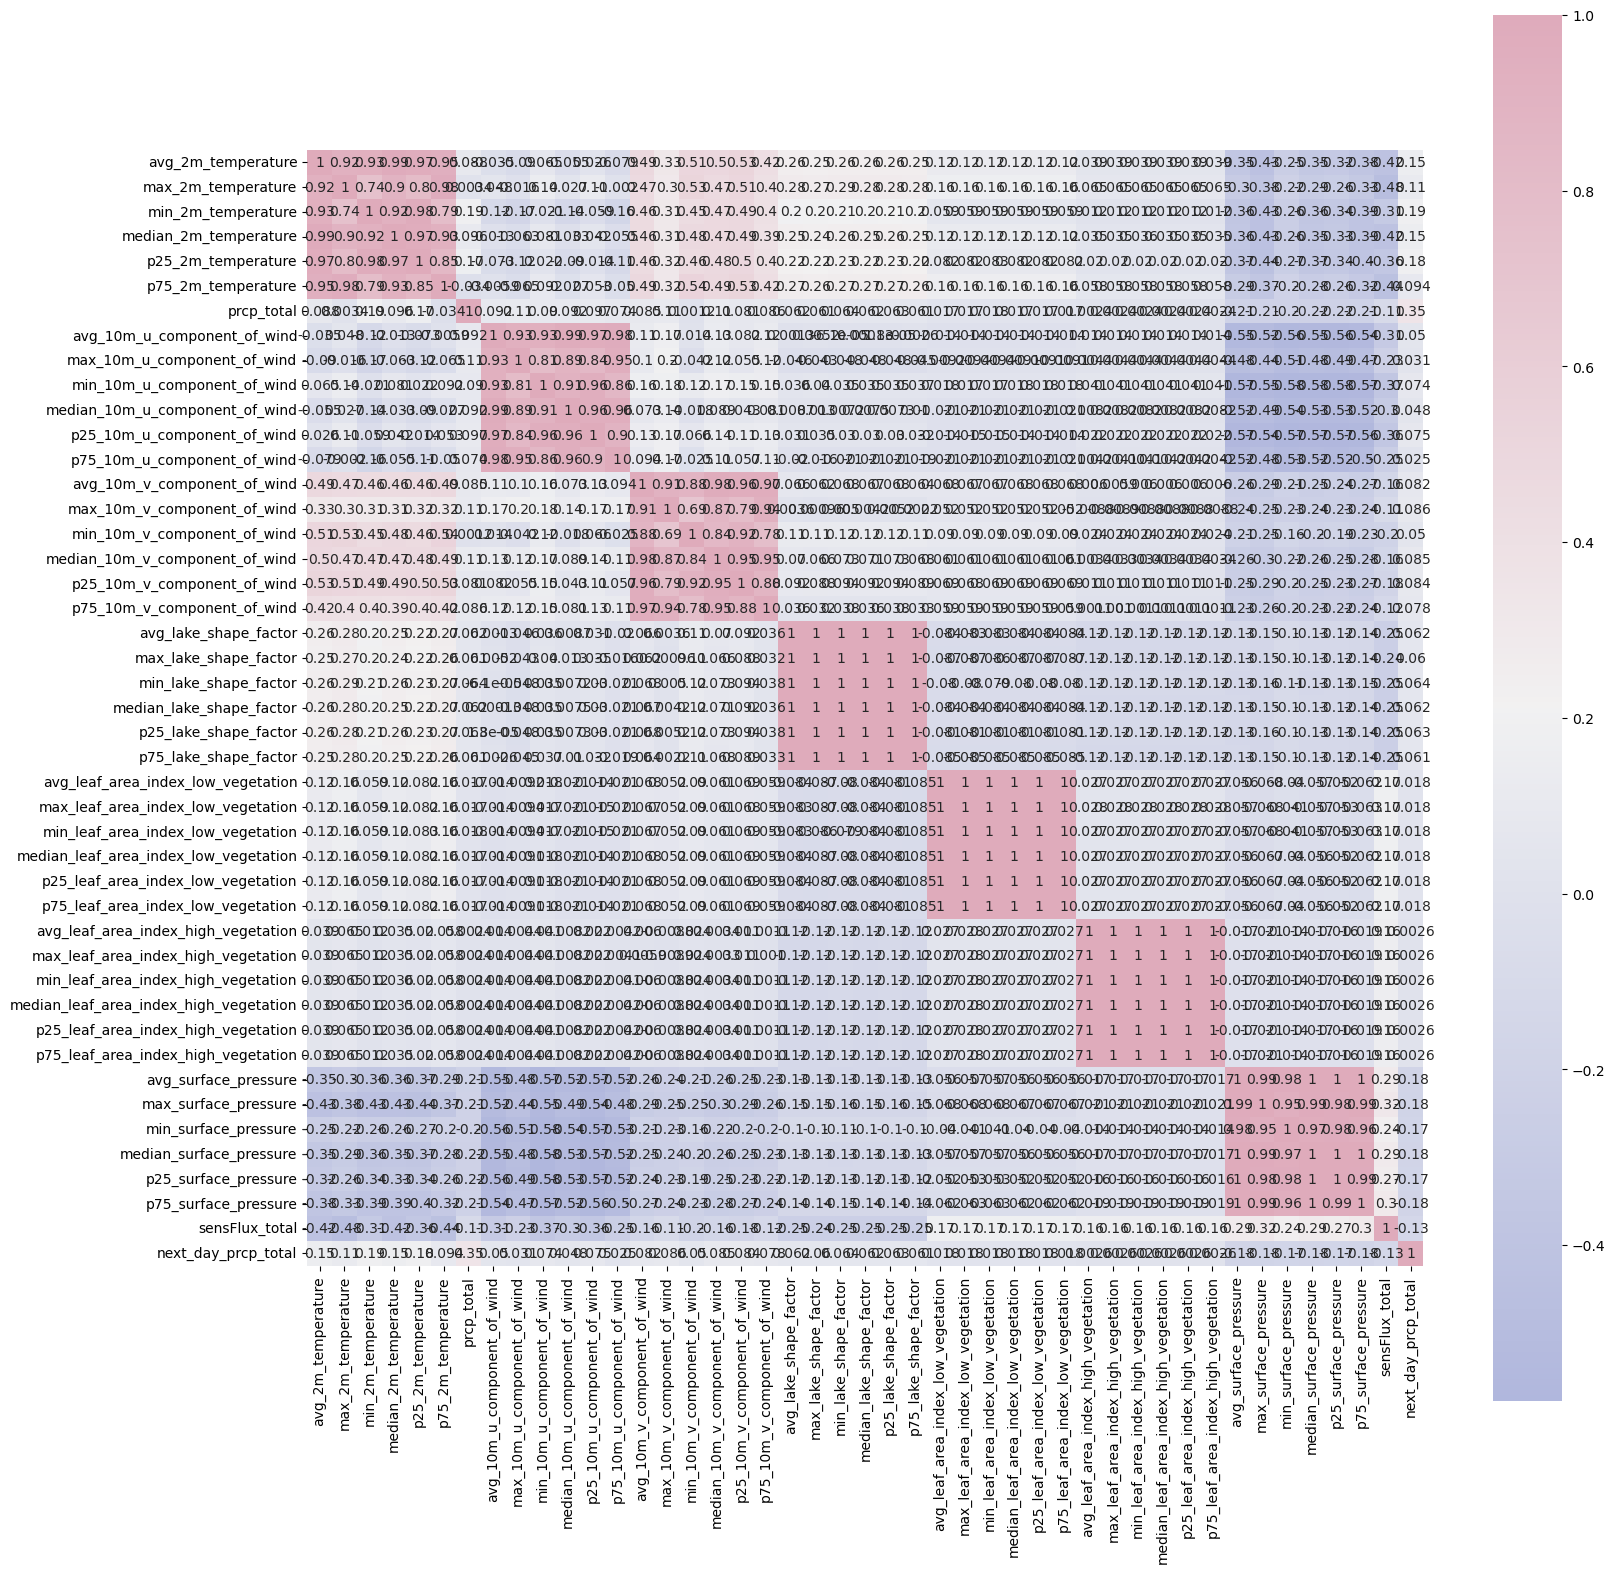

In [25]:
# Extract column names not listed in the exclusion list
col_names = [col for col in dataframes['01'].columns if col not in exclude_columns]
# Set up a standard scaler for the features
features = X
features = pd.DataFrame(features, columns=col_names) 
#full data
features['next_day_prcp_total'] = y
data = features
# Correlation amongst numeric attributes
corrmat = data.corr()
cmap = sns.diverging_palette(260,-10,s=50, l=75, n=6, as_cmap=True)
plt.subplots(figsize=(18,18))
sns.heatmap(corrmat,cmap= cmap,annot=True, square=True)

<AxesSubplot:>

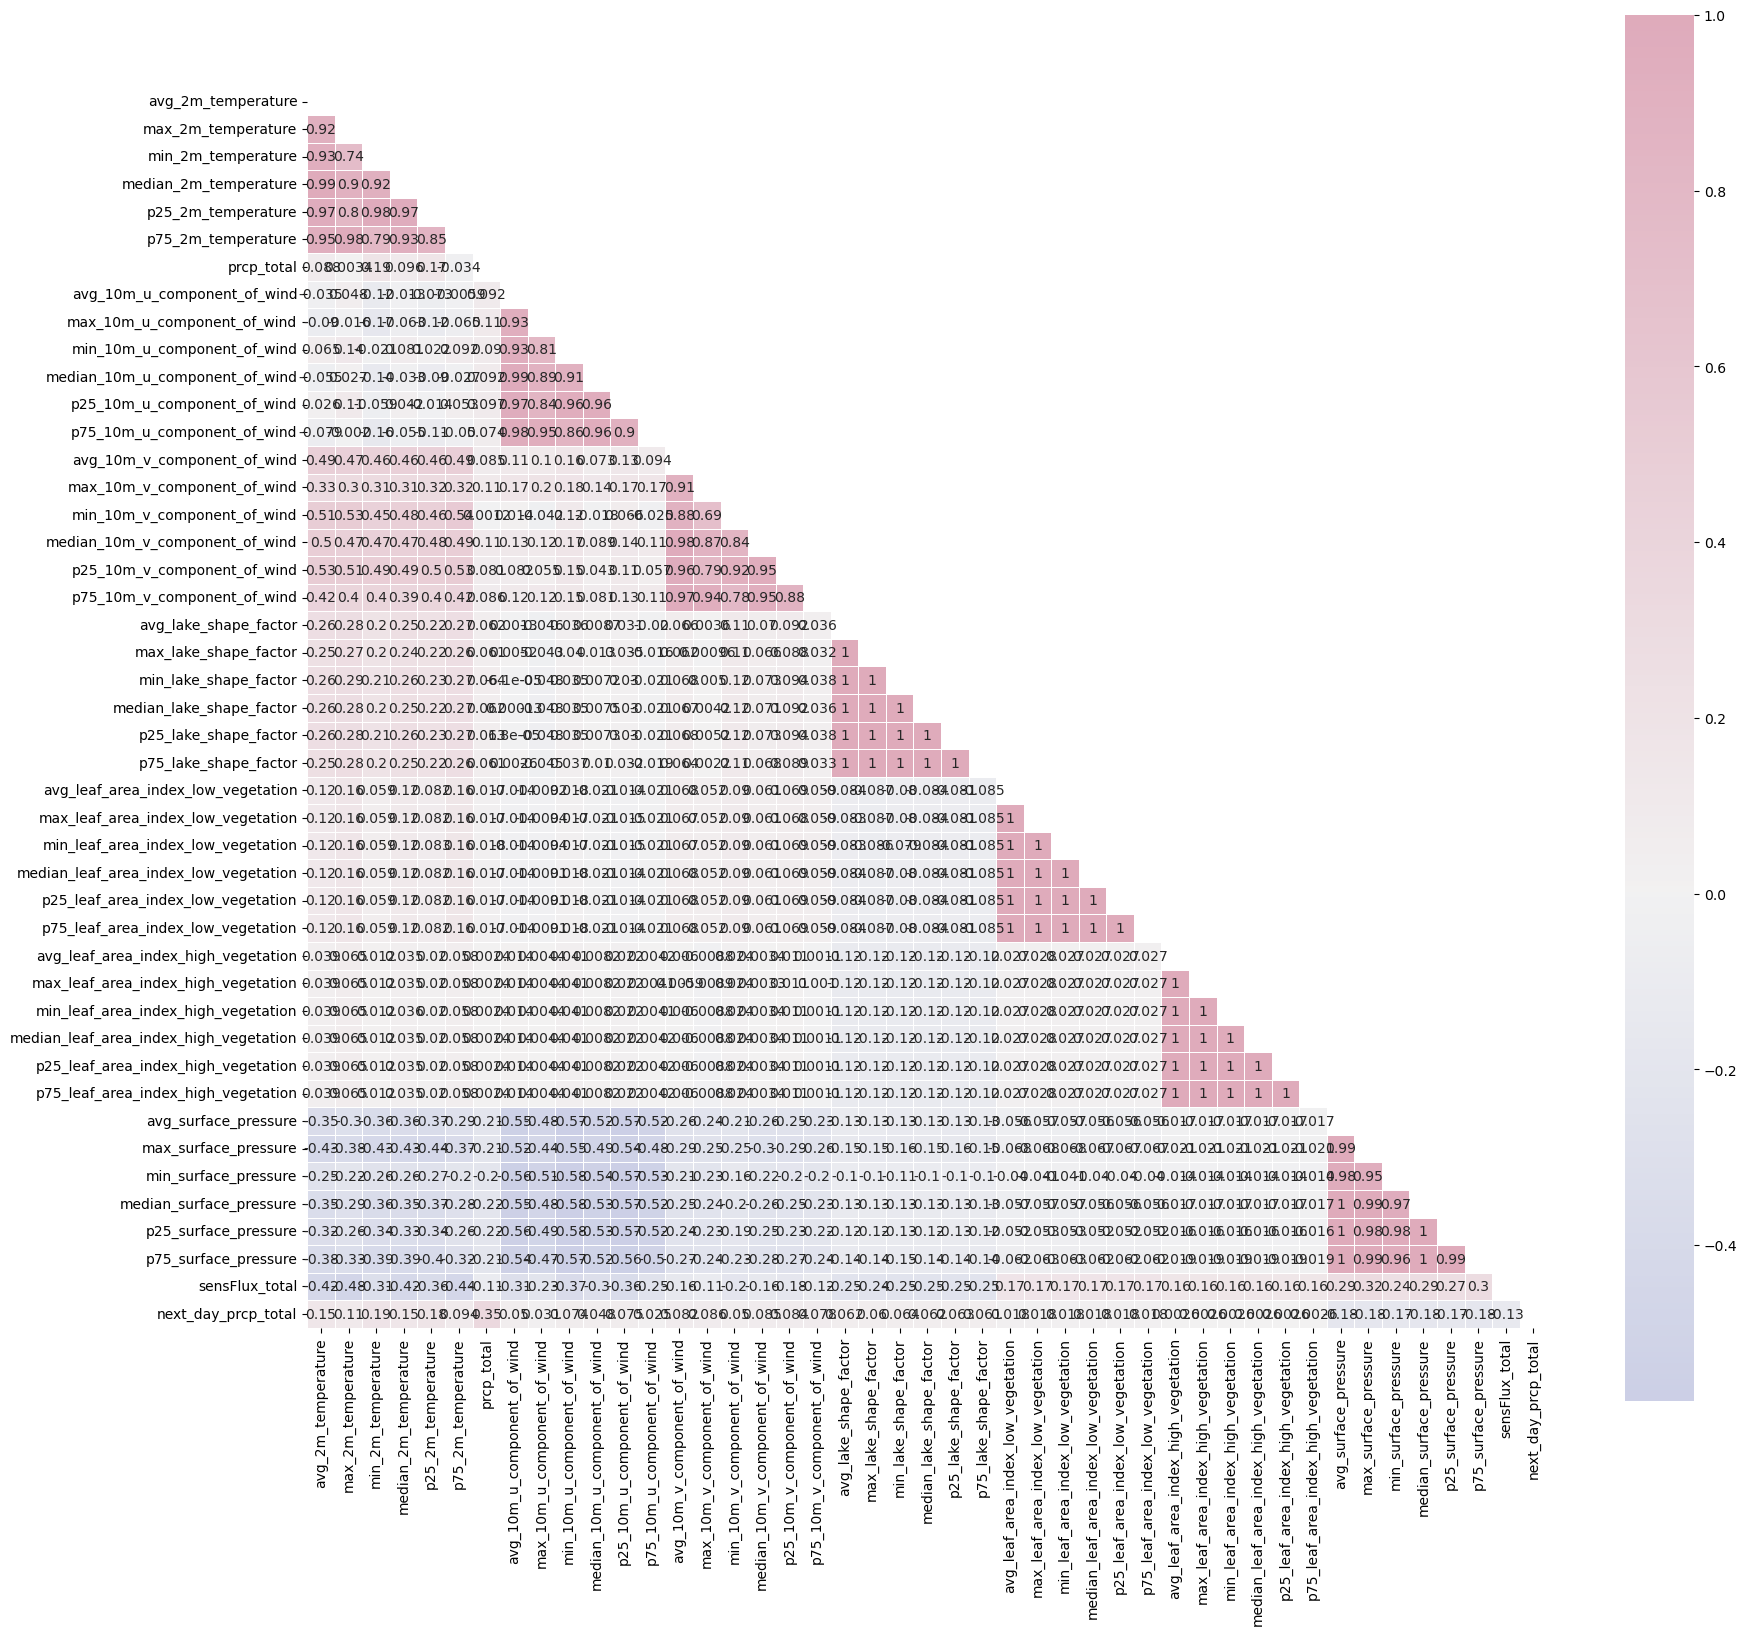

In [26]:
# Correlation Heatmap
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
corr = data.corr()
mask = np.triu(np.ones_like(corr)) #this and the next line make the correlation plot half
f, ax = plt.subplots(figsize=(20, 20))
cmap = sns.diverging_palette(260,-10,s=50, l=75, n=6, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=None, center=0,square=True, annot=True, linewidths=.5, cbar_kws={"shrink": .9})

**<span style="font-size: 24px;">Standardize Features</span>**

In [27]:
# Extract column names not listed in the exclusion list
col_names = [col for col in dataframes['01'].columns if col not in exclude_columns]

# Set up a standard scaler for the features
s_scaler = StandardScaler()
features = s_scaler.fit_transform(X)
features = pd.DataFrame(features, columns=col_names) 

features.describe().T

count          mean       std  \
avg_2m_temperature                      101835.0 -4.979067e-16  1.000005   
max_2m_temperature                      101835.0  1.339659e-16  1.000005   
min_2m_temperature                      101835.0  4.242254e-17  1.000005   
median_2m_temperature                   101835.0  2.098800e-16  1.000005   
p25_2m_temperature                      101835.0 -5.738207e-16  1.000005   
p75_2m_temperature                      101835.0 -1.594195e-15  1.000005   
prcp_total                              101835.0 -9.879987e-17  1.000005   
avg_10m_u_component_of_wind             101835.0 -5.805190e-17  1.000005   
max_10m_u_component_of_wind             101835.0 -3.572425e-17  1.000005   
min_10m_u_component_of_wind             101835.0 -3.572425e-17  1.000005   
median_10m_u_component_of_wind          101835.0 -2.009489e-17  1.000005   
p25_10m_u_component_of_wind             101835.0  1.562936e-17  1.000005   
p75_10m_u_component_of_wind             101835.0 -2.902595e-17  1.000005   
avg_10m_v_component_of_wind             101835.0  5.302818e-18  1.000005   
max_10m_v_component_of_wind             101835.0 -6.251743e-17  1.000005   
min_10m_v_component_of_wind             101835.0 -1.032654e-17  1.000005   
median_10m_v_component_of_wind          101835.0 -1.925760e-17  1.000005   
p25_10m_v_component_of_wind             101835.0  4.632988e-17  1.000005   
p75_10m_v_component_of_wind             101835.0 -1.786212e-17  1.000005   
avg_lake_shape_factor                   101835.0  1.431203e-15  1.000005   
max_lake_shape_factor                   101835.0  2.012838e-15  1.000005   
min_lake_shape_factor                   101835.0  9.065028e-16  1.000005   
median_lake_shape_factor                101835.0 -7.959809e-16  1.000005   
p25_lake_shape_factor                   101835.0 -1.903433e-15  1.000005   
p75_lake_shape_factor                   101835.0 -9.165502e-16  1.000005   
avg_leaf_area_index_low_vegetation      101835.0  2.188110e-16  1.000005   
max_leaf_area_index_low_vegetation      101835.0 -4.420876e-16  1.000005   
min_leaf_area_index_low_vegetation      101835.0 -1.964834e-16  1.000005   
median_leaf_area_index_low_vegetation   101835.0  3.840357e-16  1.000005   
p25_leaf_area_index_low_vegetation      101835.0  3.840357e-16  1.000005   
p75_leaf_area_index_low_vegetation      101835.0  3.840357e-16  1.000005   
avg_leaf_area_index_high_vegetation     101835.0  1.205693e-16  1.000005   
max_leaf_area_index_high_vegetation     101835.0  8.596147e-17  1.000005   
min_leaf_area_index_high_vegetation     101835.0 -3.248674e-16  1.000005   
median_leaf_area_index_high_vegetation  101835.0  8.931062e-18  1.000005   
p25_leaf_area_index_high_vegetation     101835.0  8.931062e-18  1.000005   
p75_leaf_area_index_high_vegetation     101835.0  8.931062e-18  1.000005   
avg_surface_pressure                    101835.0 -9.415572e-15  1.000005   
max_surface_pressure                    101835.0  5.422941e-14  1.000005   
min_surface_pressure                    101835.0 -5.090817e-14  1.000005   
median_surface_pressure                 101835.0  3.916271e-15  1.000005   
p25_surface_pressure                    101835.0 -3.864917e-15  1.000005   
p75_surface_pressure                    101835.0 -5.269996e-14  1.000005   
sensFlux_total                          101835.0  2.232766e-17  1.000005   

                                             min       25%       50%  \
avg_2m_temperature                     -5.034658 -0.445812  0.234201   
max_2m_temperature                     -4.635613 -0.567524  0.167113   
min_2m_temperature                     -5.197687 -0.393267  0.267346   
median_2m_temperature                  -5.251599 -0.453864  0.218240   
p25_2m_temperature                     -5.209468 -0.406499  0.253726   
p75_2m_temperature                     -4.711178 -0.500744  0.195256   
prcp_total                             -0.499810 -0.481841 -0.389278   
avg_10m_u_component_of_wind            -4.1019

**<span style="font-size: 24px;">Outlier Removal</span>**

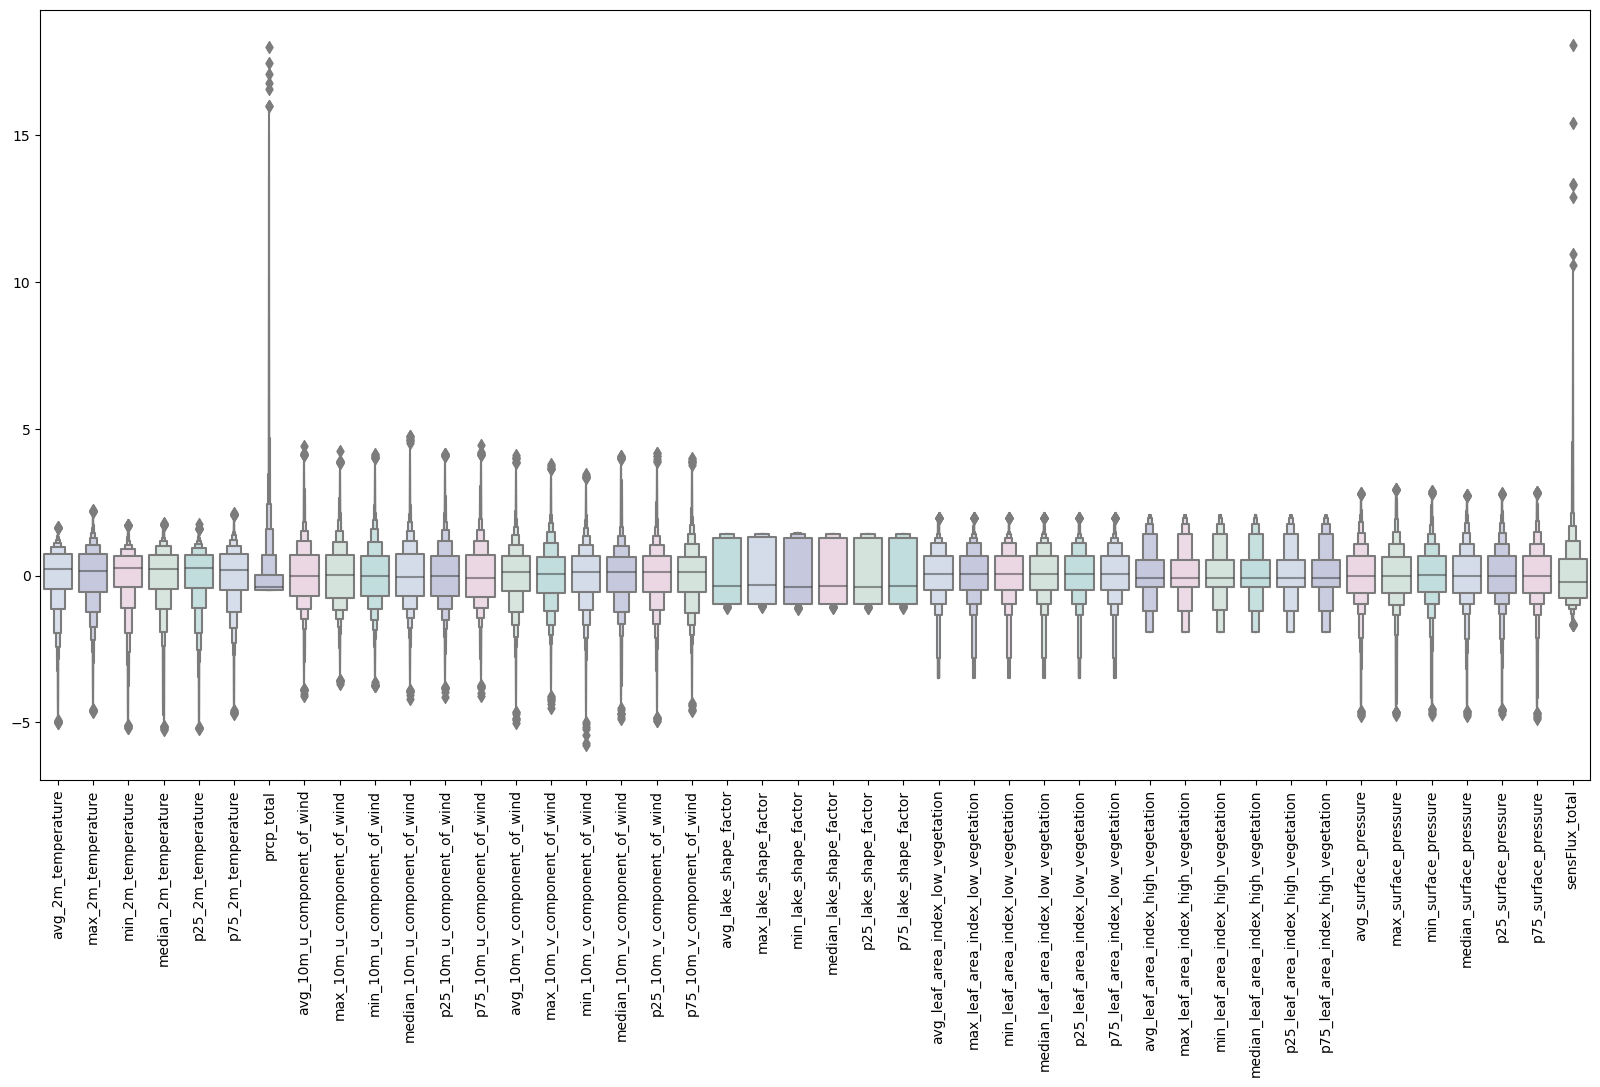

In [28]:
#Detecting outliers
#looking at the scaled features
colours = ["#D0DBEE", "#C2C4E2", "#EED4E5", "#D1E6DC", "#BDE2E2"]
plt.figure(figsize=(20,10))
sns.boxenplot(data = features,palette = colours)
plt.xticks(rotation=90)
plt.show()

In [29]:
#full data for 
features['next_day_prcp_total'] = y

#Dropping outlier
features = features[(features.apply(lambda x: (x > -6) & (x < 6)).all(axis=1))]


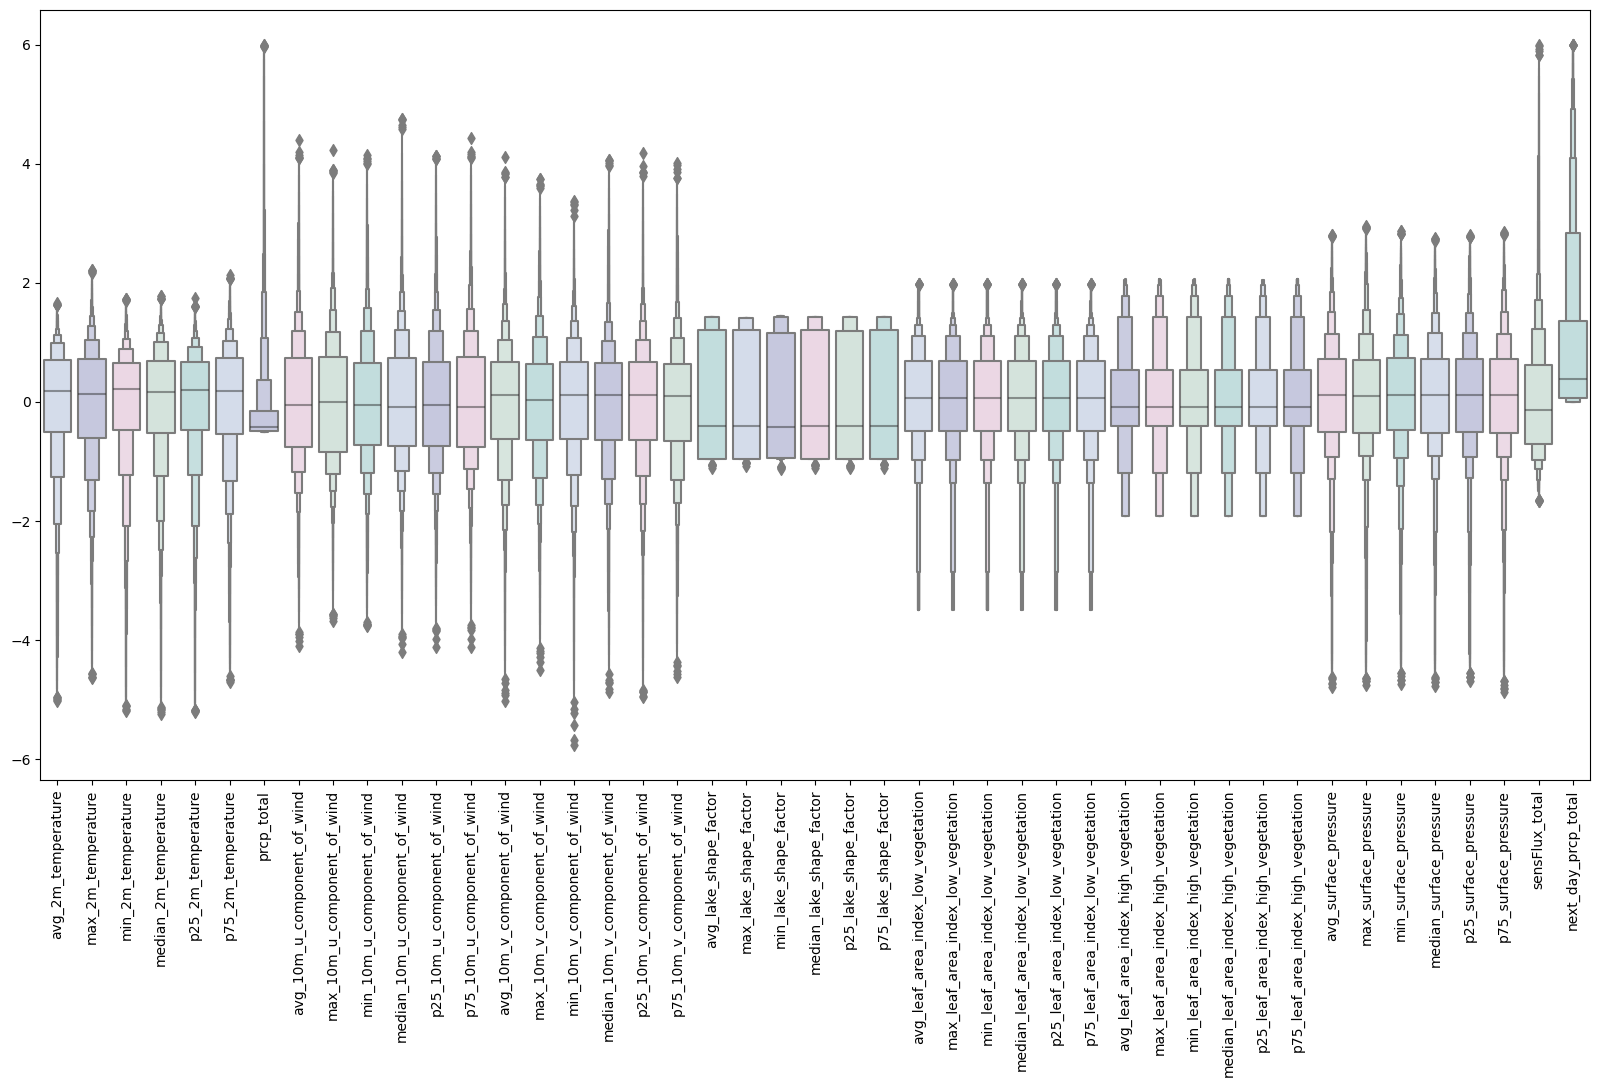

In [30]:
#looking at the scaled features without outliers

plt.figure(figsize=(20,10))
sns.boxenplot(data = features,palette = colours)
plt.xticks(rotation=90)
plt.show()

**<span style="font-size: 24px;">Model Building</span>**

In [31]:
X = features.drop(['next_day_prcp_total'], axis=1)
y = features['next_day_prcp_total']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

**<span style="font-size: 24px;">Regression Analysis - Neural Network</span>**

In [32]:
# Build your neural network model
model = keras.Sequential([
    keras.layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dense(1)  # Output layer with a single neuron for regression
])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error', metrics = ['accuracy'])

# Train the model
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

# Evaluate the model on the test set
loss = model.evaluate(X_test, y_test)
print(f"Mean Squared Error on Test Set: {loss}")

Epoch 1/10
2199/2199 [==============================] - 3s 987us/step - loss: 1.4159 - accuracy: 0.0062 - val_loss: 1.2982 - val_accuracy: 0.0065
Epoch 2/10
2199/2199 [==============================] - 2s 992us/step - loss: 1.2515 - accuracy: 0.0063 - val_loss: 1.2434 - val_accuracy: 0.0063
Epoch 3/10
2199/2199 [==============================] - 2s 1ms/step - loss: 1.1645 - accuracy: 0.0063 - val_loss: 1.1340 - val_accuracy: 0.0067
Epoch 4/10
2199/2199 [==============================] - 2s 927us/step - loss: 1.0908 - accuracy: 0.0065 - val_loss: 1.0625 - val_accuracy: 0.0060
Epoch 5/10
2199/2199 [==============================] - 2s 928us/step - loss: 1.0347 - accuracy: 0.0064 - val_loss: 1.0337 - val_accuracy: 0.0066
Epoch 6/10
2199/2199 [==============================] - 2s 919us/step - loss: 0.9920 - accuracy: 0.0064 - val_loss: 1.0250 - val_accuracy: 0.0069
Epoch 7/10
2199/2199 [==============================] - 2s 980us/step - loss: 0.9523 - accuracy: 0.0066 - val_loss: 0.9556 - v

In [33]:
#Shape Check
print(f"Shape of y: {y.shape}, shape of X: {X.shape}")
num_features = X.shape[1]
print(f"Number of features in X: {num_features}")
num_samples = X.shape[0]
print(f"Number of data points in X: {num_samples}")

Shape of y: (87941,), shape of X: (87941, 44)
Number of features in X: 44
Number of data points in X: 87941


In [34]:
X_train

avg_2m_temperature  max_2m_temperature  min_2m_temperature  \
79818            0.232389            0.307414            0.265452   
84978            0.415915           -0.266578            0.869107   
73508            0.570201            0.394050            0.559886   
74525            0.759081            0.925019            0.375065   
5722            -2.555482           -1.915802           -2.992342   
...                   ...                 ...                 ...   
6476            -2.975007           -2.004734           -3.115682   
61801            1.007030            1.262306            0.971013   
89295            0.365967            0.628660            0.094047   
861             -2.635922           -2.559760           -2.783746   
17221            0.130717            0.635691           -0.342037   

       median_2m_temperature  p25_2m_temperature  p75_2m_temperature  \
79818               0.063941            0.195049            0.304532   
84978               0.494186            0.657885            0.049858   
73508               0.374885            0.456328            0.716668   
74525               0.689314            0.547347            1.054752   
5722               -2.455190           -2.694530           -2.237179   
...                      ...                 ...                 ...   
6476               -3.182690           -3.356558           -2.215072   
61801               0.799301            0.985170            0.863329   
89295               0.506025            0.308550            0.219992   
861                -2.343918           -2.649935           -2.469096   
17221               0.263425           -0.165473            0.401993   

       prcp_total  avg_10m_u_component_of_wind  max_10m_u_component_of_wind  \
79818   -0.490106                    -1.073375                    -1.091333   
84978   -0.246551                     0.137905                     0.269213   
73508   -0.073325                     0.721354                     0.687022   
74525   -0.401269                     0.221986                     0.325027   
5722    -0.499708                     0.160578                     0.270192   
...           ...                          ...                          ...   
6476    -0.499554                    -0.273495                    -0.282832   
61801    0.122988                    -0.168159                     0.265845   
89295    0.071159                     1.239191                     0.621347   
861     -0.499657                     1.187089                     1.437304   
17221   -0.491369                     0.982181                     1.835750   

       min_10m_u_component_of_wind  ...  \
79818                    -0.896594  ...   
84978                     0.164926  ...   
73508                     0.910171  ...   
74525                     0.652807  ...   
5722                     -0.149859  ...   
...                            ...  ...   
6476                     -0.449211  ...   
61801                    -0.099606  ...   
89295                     1.672856  ...   
861                       0.762572  ...   
17221                     0.514892  ...   

       median_leaf_area_index_high_vegetation  \
79818                               -0.138814   
84978                                0.082756   
73508                                0.818529   
74525                               -0.100549   
5722                                -0.212488   
...                                       ...   
6476                                -0.425494   
61801                               -0.525320   
89295                                1.637147   
861                                  0.050990   
17221                               -1.918176   

       p25_leaf_area_index_high_vegetation  \
79818                            -0.138814   
84978                             0.082756   
73508                             0.818529   
74525                            -0.100549   
5722                        

In [35]:
y_train

79818    0.025626
84978    1.936733
73508    4.237180
74525    3.612345
5722     0.724529
           ...   
6476     0.000811
61801    1.091071
89295    0.342891
861      0.247908
17221    0.093117
Name: next_day_prcp_total, Length: 70352, dtype: float64

In [36]:
# show a summary of the data
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 64)                2880      
                                                                 
 dense_4 (Dense)             (None, 32)                2080      
                                                                 
 dense_5 (Dense)             (None, 1)                 33        
                                                                 
Total params: 4993 (19.50 KB)
Trainable params: 4993 (19.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [37]:
# Display training progress by printing a single dot for each completed epoch
class PrintDot(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        if epoch % 100 == 0: print('')
        print('.', end='')
        
# Function to plot how the model is doing during training
# Visualize the model's training progress using the stats stored in the history object. 
# We want to use this data to determine how long to train before the model stops making progress.
def plot_history(history):
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Abs Error [mm]')
    plt.plot(history.epoch, np.array(history.history['loss']),
           label='Train Loss')
    plt.plot(history.epoch, np.array(history.history['val_loss']),
           label = 'Val loss')
    plt.legend()
    #plt.ylim([0, 5])


....................................................................................................
....................................................................................................
....................................................................................................
................

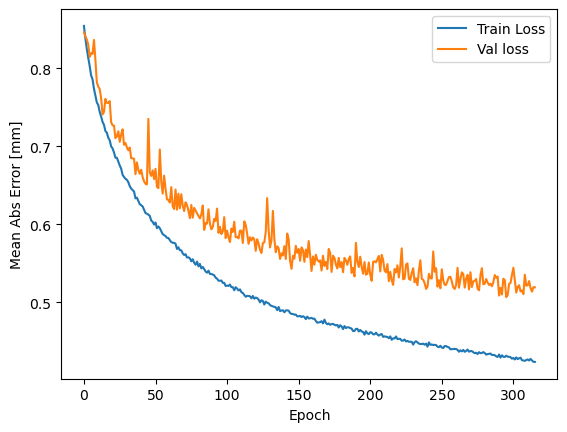

In [38]:
# If you train too long, you are prone to over-fitting
# this prevents the model from generalizing to data it has never seen before
# early stopping is one way to go about this
# The patience parameter is the amount of epochs to check for improvement
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)

# Store training stats
history = model.fit(X_train, y_train, epochs=1000,
                    validation_split=0.2, verbose=0,
                    callbacks=[early_stop, PrintDot()])

plot_history(history)

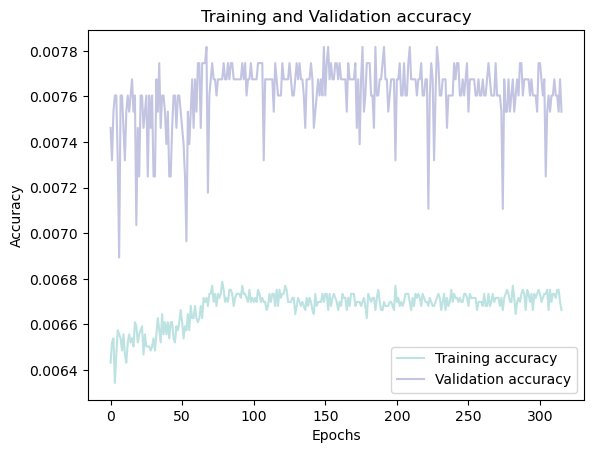

In [39]:
history_df = pd.DataFrame(history.history)

plt.plot(history_df.loc[:, ['accuracy']], "#BDE2E2", label='Training accuracy')
plt.plot(history_df.loc[:, ['val_accuracy']], "#C2C4E2", label='Validation accuracy')

plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [40]:
print(history_df.columns)

Index(['loss', 'accuracy', 'val_loss', 'val_accuracy'], dtype='object')


In [41]:
# Calculate MAE separately
from sklearn.metrics import mean_absolute_error
y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
print(f"Mean Absolute Error on Test Set: {mae} millimeters")

550/550 [==============================] - 0s 610us/step
Mean Absolute Error on Test Set: 0.49963837013543955 millimeters


550/550 [==============================] - 0s 697us/step


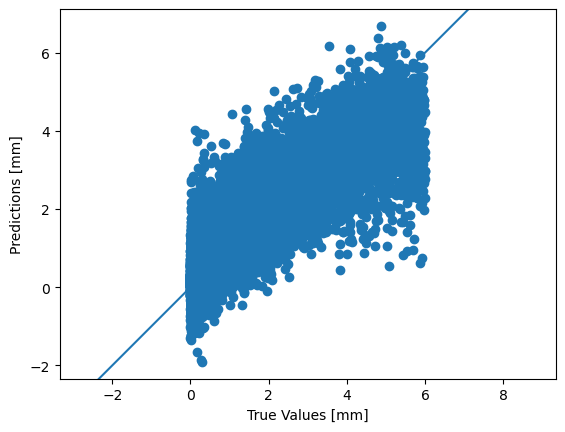

In [42]:
test_predictions = model.predict(X_test).flatten()

plt.scatter(y_test, test_predictions)
plt.xlabel('True Values [mm]')
plt.ylabel('Predictions [mm]')
plt.axis('equal')
plt.xlim(plt.xlim())
plt.ylim(plt.ylim())
_ = plt.plot([-100, 100], [-100, 100])

In [43]:
np.corrcoef(y_test,test_predictions)[0,1]

0.859459211605894

In [44]:
from sklearn.metrics import r2_score
r2_score(y_test,test_predictions)

0.7321772732599012

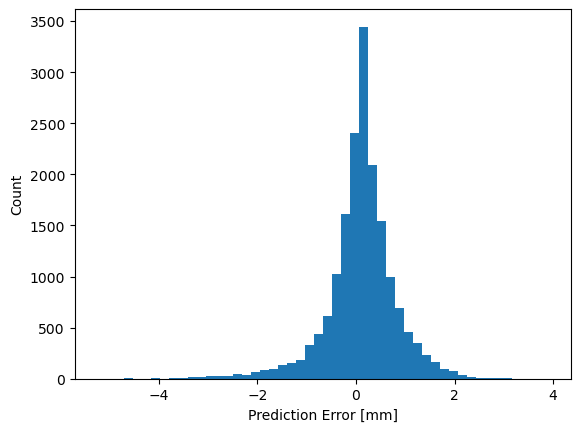

In [45]:
error = test_predictions - y_test
plt.hist(error, bins = 50)
plt.xlabel("Prediction Error [mm]")
_ = plt.ylabel("Count")

In [46]:
joblib.dump(model, "nn_rain_ext.pkl")

['nn_rain_ext.pkl']

**<span style="font-size: 24px;">Categorical Analysis - Data Preprocessing</span>**

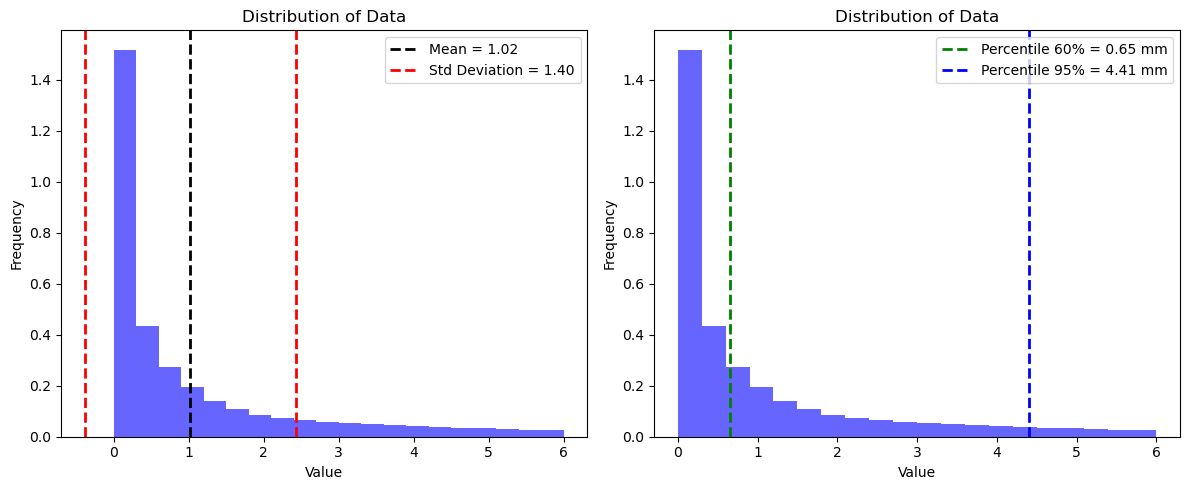

Category 0 is from 0 to 0.649 mm of rain
Number of data points below the 60.0% percentile: 42211
Category 1 is from 0.649 mm of rain to 4.408 mm of rain
Number of data points in the 60.0% to 95.0% range: 24623
Category 2 is from 4.408 mm of rain to the maximum
Number of data points above the 95.0% percentile: 3518


In [64]:
# Calculate statistics
mean = np.mean(y_train)
std_dev = np.std(y_train)

# Calculate the percentiles
a = 0.6
b = 0.95
percentile_a = y_train.quantile(a)
percentile_b = y_train.quantile(b)

# Count data points within the percentile ranges
count_below_a = np.sum(y_train < percentile_a)
count_a_to_b = np.sum((y_train >= percentile_a) & (y_train <= percentile_b))
count_above_b = np.sum(y_train > percentile_b)

# Create subplots with two histograms
plt.figure(figsize=(12, 5))  # Adjust the figure size as needed

plt.subplot(1, 2, 1)  # 1 row, 2 columns, subplot 1
plt.hist(y_train, bins=20, density=True, alpha=0.6, color='b')
plt.axvline(mean, color='k', linestyle='dashed', linewidth=2, label=f"Mean = {mean:.2f}")
plt.axvline(mean + std_dev, color='r', linestyle='dashed', linewidth=2, label=f"Std Deviation = {std_dev:.2f}", )
plt.axvline(mean - std_dev, color='r', linestyle='dashed', linewidth=2)
plt.legend()
plt.title("Distribution of Data")
plt.xlabel("Value")
plt.ylabel("Frequency")

plt.subplot(1, 2, 2)  # 1 row, 2 columns, subplot 2
plt.hist(y_train, bins=20, density=True, alpha=0.6, color='b')
plt.axvline(percentile_a, color='g', linestyle='dashed', linewidth=2, label=f"Percentile {int(a*100)}% = {percentile_a:.2f} mm")
plt.axvline(percentile_b, color='b', linestyle='dashed', linewidth=2, label=f"Percentile {int(b*100)}% = {percentile_b:.2f} mm", )
plt.legend()
plt.title("Distribution of Data")
plt.xlabel("Value")
plt.ylabel("Frequency")

plt.tight_layout()  # Adjust spacing between subplots
plt.show()

print('Category 0 is from 0 to ' + str(round(percentile_a, 3)) + ' mm of rain')
print(f"Number of data points below the {a*100}% percentile: {count_below_a}")
print('Category 1 is from ' + str(round(percentile_a, 3)) + ' mm of rain to ' + str(round(percentile_b, 3)) + ' mm of rain')
print(f"Number of data points in the {a*100}% to {b*100}% range: {count_a_to_b}")
print('Category 2 is from ' + str(round(percentile_b, 3)) + ' mm of rain to the maximum')
print(f"Number of data points above the {b*100}% percentile: {count_above_b}")

In [48]:
import pandas as pd

# Create categorical labels based on percentiles
y_train_category = pd.cut(
    y_train,
    bins=[float('-inf'), percentile_a, percentile_b, float('inf')],
    labels=['0', '1', '2']
)

# Repeat the same process for y_test
y_test_category = pd.cut(
    y_test,
    bins=[float('-inf'), percentile_a, percentile_b, float('inf')],
    labels=['0', '1', '2']
)


**<span style="font-size: 24px;">Categorical Analysis - Pairwise Correlation</span>**

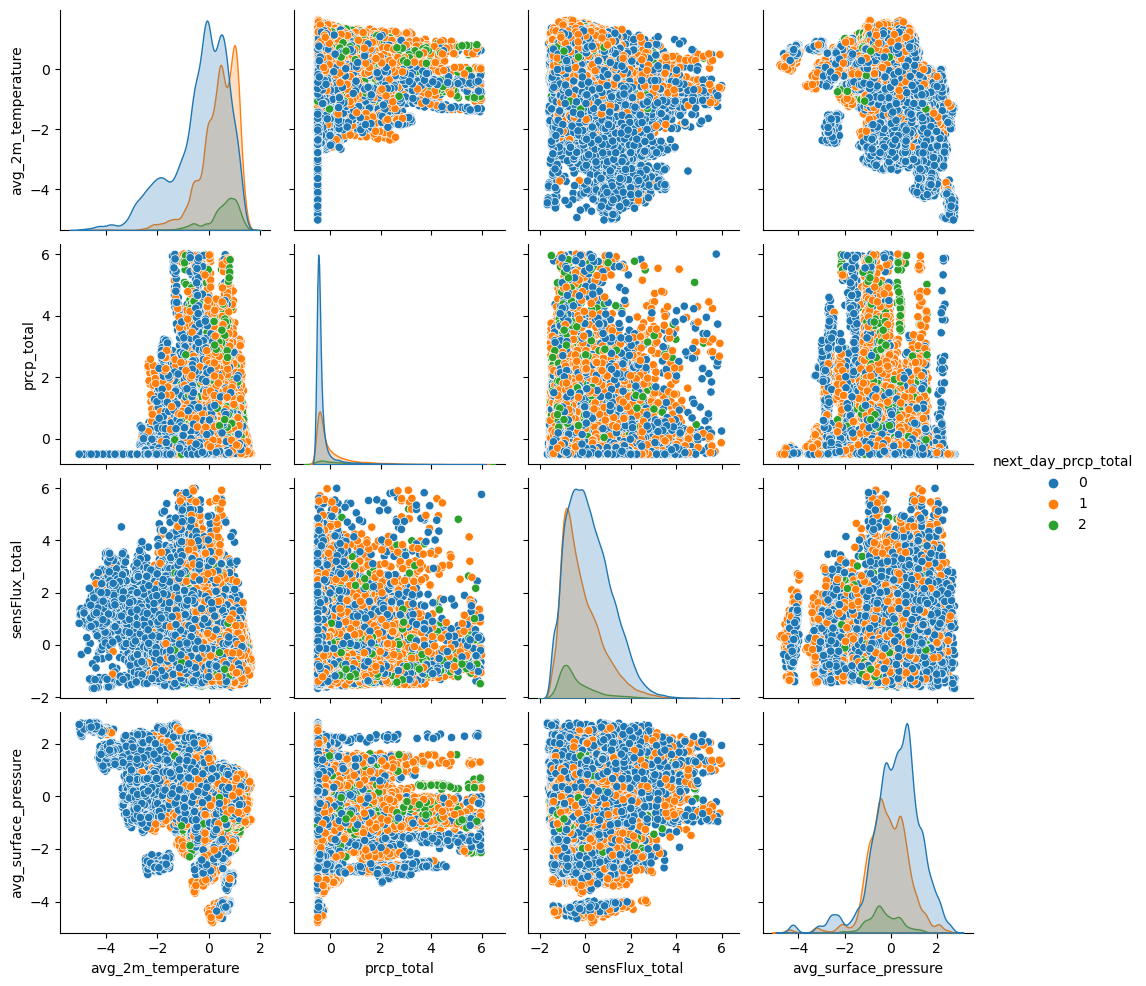

In [50]:
X_cat = pd.concat([X_train, X_test,])
y_cat = pd.concat([y_train_category, y_test_category])
X_cat['next_day_prcp_total'] = y_cat
data_cat = X_cat
sns.pairplot( data=data_cat, vars=('avg_2m_temperature','prcp_total','sensFlux_total','avg_surface_pressure'), hue='next_day_prcp_total' )


**<span style="font-size: 24px;">Categorical Analysis - Model Building</span>**


In [51]:
import time
from sklearn.metrics import accuracy_score, cohen_kappa_score, classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
def run_model(model, X_train, y_train_category, X_test, y_test_category, verbose=True):
    t0=time.time()
    if verbose == False:
        model.fit(X_train,y_train_category, verbose=0)
    else:
        model.fit(X_train,y_train_category)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test_category, y_pred)
    coh_kap = cohen_kappa_score(y_test_category, y_pred)
    time_taken = time.time()-t0
    print("Accuracy = {}".format(accuracy))
    print("Cohen's Kappa = {}".format(coh_kap))
    print("Time taken = {}".format(time_taken))
    print(classification_report(y_test_category,y_pred,digits=5))
    
    cm = confusion_matrix(y_test_category, y_pred, labels=model.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                             display_labels=model.classes_)
    disp.plot()
    plt.show()
    
    return model, accuracy, coh_kap, time_taken

**<span style="font-size: 24px;">Categorical Analysis - Random Forest</span>**


Accuracy = 0.8812325885496617
Cohen's Kappa = 0.7629494301309725
Time taken = 78.52775526046753
              precision    recall  f1-score   support

           0    0.92500   0.94451   0.93465     10524
           1    0.80980   0.87138   0.83946      6181
           2    0.90625   0.19683   0.32342       884

    accuracy                        0.88123     17589
   macro avg    0.88035   0.67091   0.69918     17589
weighted avg    0.88357   0.88123   0.87048     17589



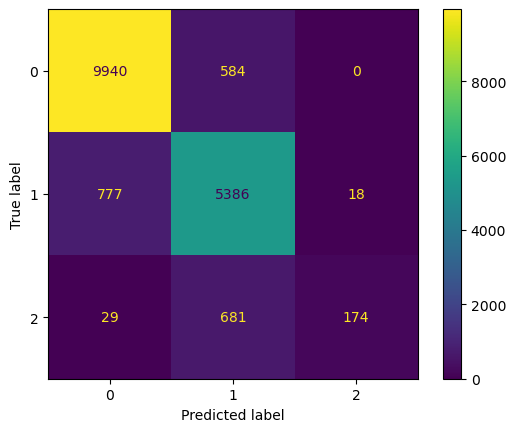

In [52]:
from sklearn.ensemble import RandomForestClassifier

params_rf = {'max_depth': 16,
             'min_samples_leaf': 1,
             'min_samples_split': 2,
             'n_estimators': 100,
             'random_state': 12345}

model_rf = RandomForestClassifier(**params_rf)
model_rf, accuracy_rf, coh_kap_rf, tt_rf = run_model(model_rf, X_train, y_train_category, X_test, y_test_category)

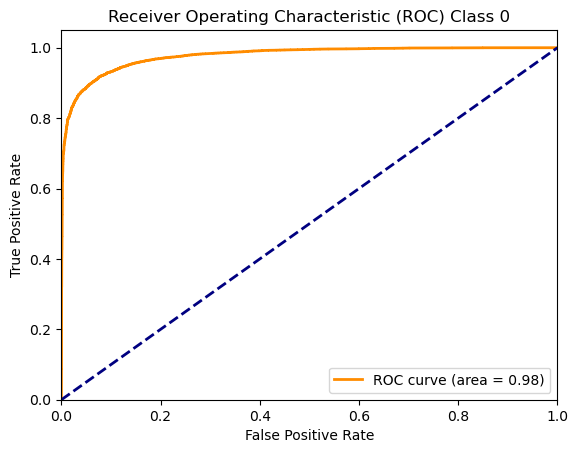

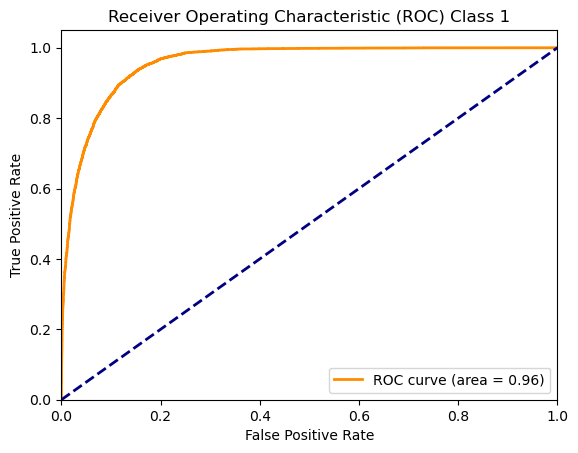

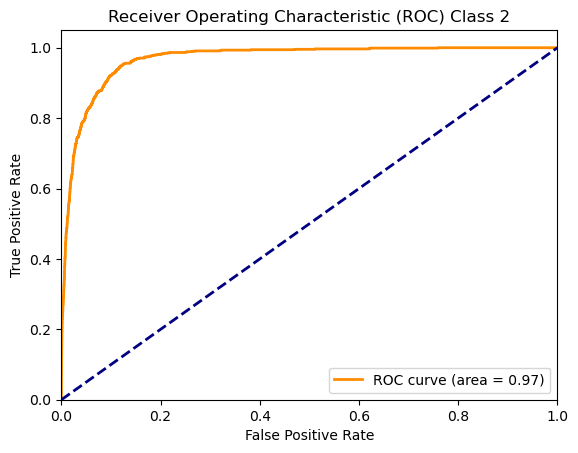

In [53]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import numpy as np

# Binarize the labels
y_test_binarized = label_binarize(y_test_category, classes=['0', '1', '2'])
n_classes = y_test_binarized.shape[1]

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

probs = model_rf.predict_proba(X_test)  # Calculate predicted probabilities


for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves for each class
for i in range(n_classes):
    plt.figure()
    plt.plot(fpr[i], tpr[i], color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc[i]))
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Class {}'.format(i))
    plt.legend(loc='lower right')
    plt.show()


In [54]:
def plot_feature_importance(importance, names):
    #Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)

    #Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)

    #Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)

    #Define size of bar plot
    plt.figure(figsize=(10,8))
    #Plot Searborn bar chart
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
    #Add chart labels
    plt.title('FEATURE IMPORTANCE')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')

In [55]:
dfxTrain=pd.DataFrame(X_train, columns=col_names)

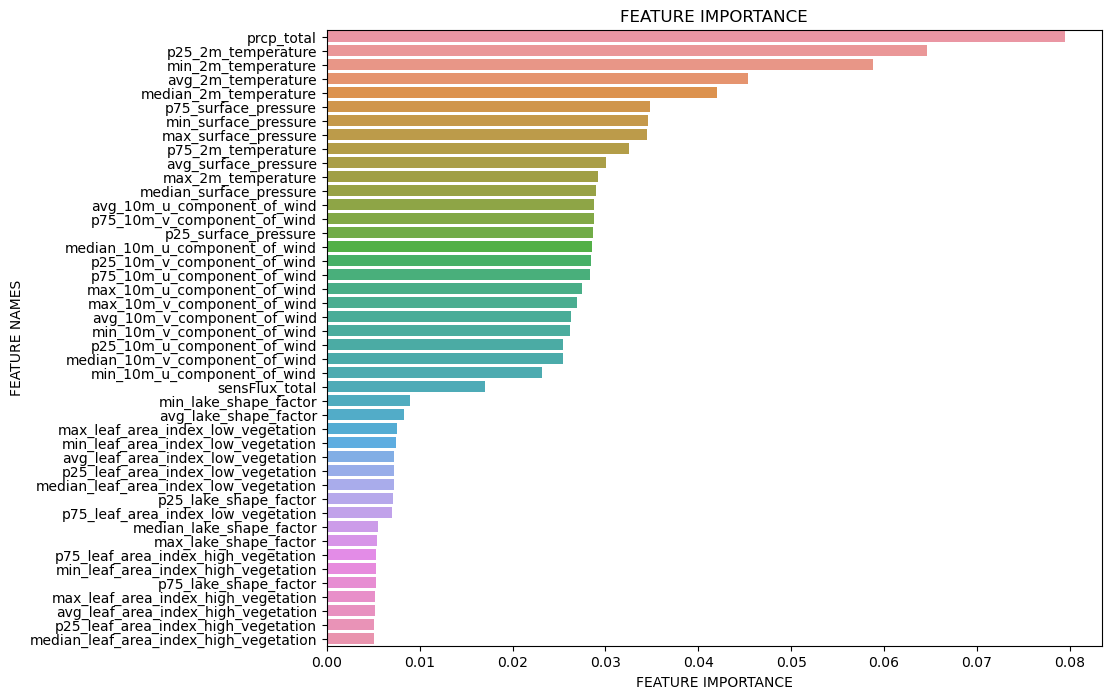

In [56]:
plot_feature_importance(model_rf.feature_importances_, dfxTrain.columns)

In [57]:
joblib.dump(model_rf, "rf_rain_ext.pkl")

['rf_rain_ext.pkl']

**<span style="font-size: 24px;">Categorical Analysis - XGBoost</span>**


Accuracy = 0.9256921939848769
Cohen's Kappa = 0.8543047922722652
Time taken = 27.836250066757202
              precision    recall  f1-score   support

           0    0.96047   0.96285   0.96166     10524
           1    0.87704   0.91975   0.89789      6181
           2    0.83303   0.52489   0.64400       884

    accuracy                        0.92569     17589
   macro avg    0.89018   0.80250   0.83452     17589
weighted avg    0.92475   0.92569   0.92328     17589



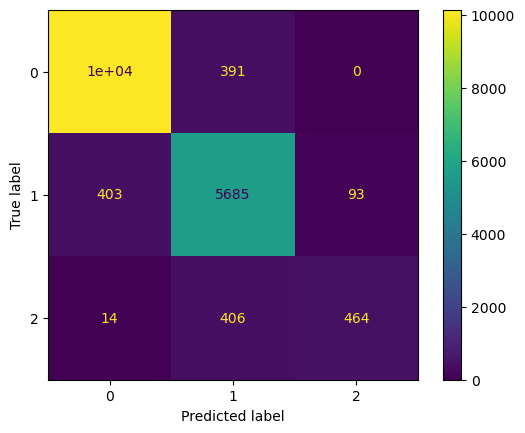

In [58]:
y_train_category = y_train_category.astype(int)
y_test_category = y_test_category.astype(int)

import xgboost as xgb
params_xgb ={'n_estimators': 500,
            'max_depth': 16}

model_xgb = xgb.XGBClassifier(**params_xgb)
model_xgb, accuracy_xgb, coh_kap_xgb, tt_xgb = run_model(model_xgb, X_train, y_train_category, X_test, y_test_category)

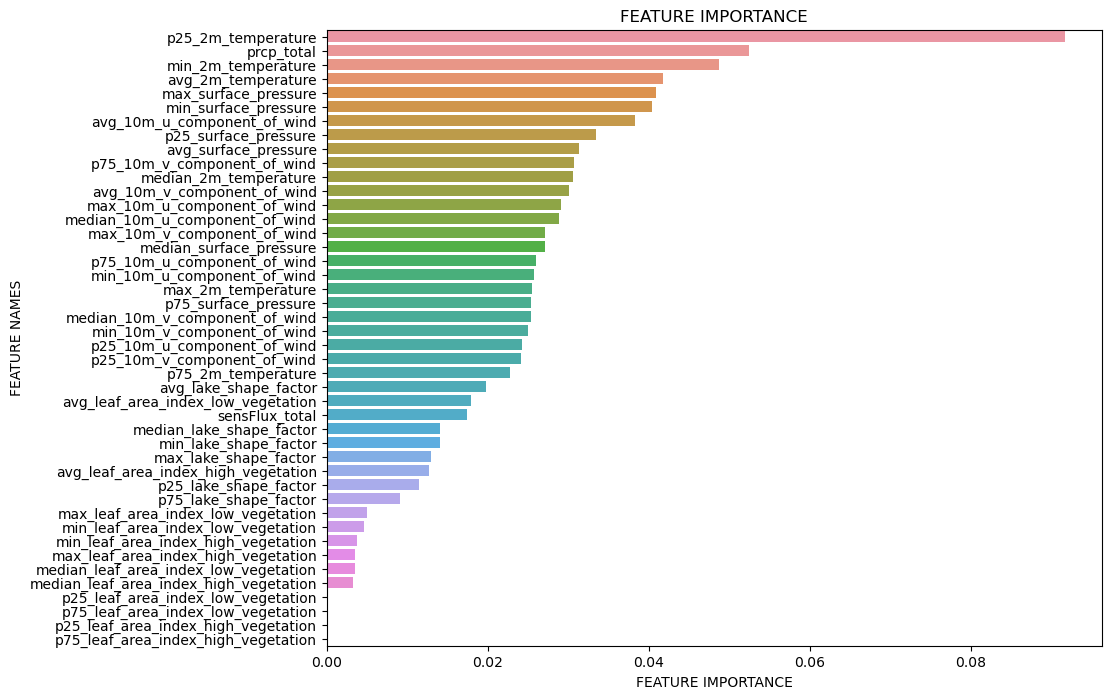

In [59]:
plot_feature_importance(model_xgb.feature_importances_, dfxTrain.columns)

**<span style="font-size: 24px;">Saving the model to reuse it again</span>**

In [60]:
joblib.dump(model_xgb, "xg_rain_ext.pkl")

['xg_rain_ext.pkl']

**<span style="font-size: 24px;">Limitations and future work</span>**

Regressors and classifiers are usually not directly compared. It would require further processing to compare them. Adding more models, for example, a random forest regression, and a multi class prediction neural network could have yielded further comparison of the possible machine learning approaches. Even though latitude (lat) and longitude (lon) were added as features in one iteration, they were removed to produce more generalized models. A more generalized model facilitates applications to other datasets. Particularly since the model was only trained on a small subset of latitude and longitude, South Florida. Also, using a model without longitude and latitude dependency, creates a more physically based model (temperature, surface pressure, etc.) as opposed to a more location based model.

**<span style="font-size: 24px;">References</span>**

*Run model function/ roc and auc curve: https://github.com/azalahmadkhan/Precipitation-Prediction-using-ML/blob/main/Precipitation_Prediction.ipynb **

*Outlier removal, training and validation accuracy, standardization, confusion matrix:https://www.kaggle.com/code/karnikakapoor/rain-prediction-ann#MODEL-BUILDING **

*Pairwise correlation, heatmap, confusion matrix: https://www.kaggle.com/code/chandrimad31/rainfall-prediction-7-popular-models#Model-Comparison **

*Plot Feature Importance: https://www.analyseup.com/learn-python-for-data-science/python-random-forest-feature-importance-plot.html **

*Saving the model to reuse it again: https://github.com/Biswajit6844/rainfall-prediction/blob/master/Xgboost%20model.ipynb **